# 前言
这是一篇粒子滤波的实践记录

In [151]:
# -- coding: utf-8 --  
from math import *
import random
from matplotlib import pyplot as plt

#机器人四个参照物
landmarks  = [[20.0, 20.0], [80.0, 80.0], [20.0, 80.0], [80.0, 20.0]]
#地图大小
world_size = 100.0


In [152]:
from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"
InteractiveShell.ast_node_interactivity = "last_expr"

In [156]:
class robot:
    def __init__(self):
        #
        self.x = random.random() * world_size
        self.y = random.random() * world_size
        self.orientation = random.random() * 2.0 * pi
        #给机器人初试化一个坐标和方向
        #方位角为0的方向即X轴正方向
        self.forward_noise = 0.0
        self.turn_noise    = 0.0
        self.sense_noise   = 0.0

    def status(self,cout = 0):
        if (cout == 1) :print('Coordinates: ({latitude}, {longitude},{orientation})'.format(latitude=self.x, longitude=self.y, orientation = self.orientation))
        return ([self.x, self.y,  self.orientation])

    def set_locate(self, new_x, new_y, new_orientation):
        #设定机器人的坐标　方向
        if new_x < 0 or new_x >= world_size:
            raise ValueError('X coordinate out of bound')
        if new_y < 0 or new_y >= world_size:
            raise ValueError('Y coordinate out of bound')
        if new_orientation < 0 or new_orientation >= 2 * pi:
            raise ValueError('Orientation must be in [0..2pi]')
        self.x = float(new_x)
        self.y = float(new_y)
        self.orientation = float(new_orientation)
    
    
    def set_noise(self, new_f_noise, new_t_noise, new_s_noise):
        # makes it possible to change the noise parameters
        # this is often useful in particle filters
        #设定一下机器人的噪声
        self.forward_noise = float(new_f_noise)
        self.turn_noise    = float(new_t_noise)
        self.sense_noise   = float(new_s_noise)
    
    
    def sense(self):
		#测量机器人到四个参照物的距离　添加一些高斯噪声
        Z = [] 
        for i in range(len(landmarks)):
            dist = sqrt((self.x - landmarks[i][0]) ** 2 + (self.y - landmarks[i][1]) ** 2)
            dist += random.gauss(0.0, self.sense_noise)
            Z.append(dist)
        return Z
    
    
    def move(self, turn, forward):
        #机器人转向　前进　并返回更新后的机器人新的坐标和噪声大小
        if forward < 0:
            raise ValueError('Robot cant move backwards')         
        
        # turn, and add randomness to the turning command
        orientation = self.orientation + float(turn) + random.gauss(0.0, self.turn_noise)
        orientation %= 2 * pi
        
        # move, and add randomness to the motion command
        dist = float(forward) + random.gauss(0.0, self.forward_noise)
        x = self.x + (cos(orientation) * dist)
        y = self.y + (sin(orientation) * dist)
        x %= world_size    # cyclic truncate
        y %= world_size
        
        # set particle
        # 返回移动后的机器人
        res = robot()
        res.set_locate(x, y, orientation)
        res.set_noise(self.forward_noise, self.turn_noise, self.sense_noise)
        return res
    
    def Gaussian(self, mu, sigma, x):
        
        # calculates the probability of x for 1-dim Gaussian with mean mu and var. sigma
        return exp(- ((mu - x) ** 2) / (sigma ** 2) / 2.0) / sqrt(2.0 * pi * (sigma ** 2))
    
    
    def measurement_prob(self, measurement):
        
        # calculates how likely a measurement should be
        #计算出的距离相对于正确正确的概率　离得近肯定大　离得远就小
        prob = 1.0
        for i in range(len(landmarks)):
            dist = sqrt((self.x - landmarks[i][0]) ** 2 + (self.y - landmarks[i][1]) ** 2) 
            # dist 这里是真实距离，因为粒子的随机设定的  是已知坐标的 
            # 根据测量值 真实值 和高斯模型计算出 此粒子的这个测量值的概率
            # 由于路标有多个  所以每个路标计算出来的测量值概率相乘
            prob *= self.Gaussian(dist, self.sense_noise, measurement[i])
        return prob

In [324]:

myrobot = robot() # 初始化一个机器人

myrobot.set_noise(0.005,0.0005,10) #设定噪声 f t s 

# myrobot.set_locate(20,20,pi/4) #设定初始位置 x y o  ,初始设定机器人x轴朝向45度方向
myrobot.set_locate(20,20,0) #设定初始位置 x y o  ,初始设定机器人x轴朝向0度方向
 
myrobot.status(1) #打印位置方向

Z=myrobot.sense()
# print (Z) #打印与四个参照物的距离
 

# myrobot=myrobot.move(pi/2,10.0) #机器人移动　
Z=myrobot.sense()


Coordinates: (20.0, 20.0,0.0)


In [325]:


Z=myrobot.sense()
N=1000  #初始化 N个粒子
T = 20  #迭代次数
p=[]    #保存粒子群的列表

for i in range( N):
    # 每个粒子是一个候选机器人
    r=robot()
    r.set_noise(0.5+random.random(),0.05+random.random(),5.0)
    p.append(r)
len(p)

1000

In [326]:
import numpy as np
import matplotlib
from IPython import display # 动态刷新
%matplotlib inline
 
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
     from IPython import display

plt.ion()

def plotParticle(p):
    plt.xlim( (1, world_size) )  # set the xlim to xmin, xmax
    plt.ylim( (1, world_size) )  # set the xlim to xmin, xmax
    
    px = list(map(lambda x:x.status()[0],p))
    py = list(map(lambda x:x.status()[1],p))

    plt.scatter(px,py)
    plt.pause(0.01) # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display()
# # 测试 在线打印粒子机器人位置
# for i in range(100):

#     p=[]    #保存粒子群的列表

#     for i in range( N):
#         # 每个粒子是一个候选机器人
#         r=robot()
#         r.set_noise(0.05+random.random(),0.05,5.0)
#         p.append(r)
# #     plt.pause(0.01)
#     plotParticle(p)

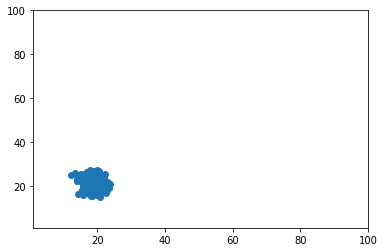

In [327]:
# 开始进行迭代
plotParticle(p)
for t in range(T):
    # 移动机器人 并测量 随着机器人的移动感知周围空间，这些粒子将获得自己的权重，然后进行筛选，
    myrobot = myrobot.move(0, 5) #向前移动 
    Z = myrobot.sense()

    p2=[]
    for i in range(N):
        p2.append(p[i].move(0,5.0))
    p=p2
    
    #计算各个粒子的权重
    w=[]
    for i in range(N):
        w.append(p[i].measurement_prob(Z))# 计算每个粒子测量值的概率，作为权重。

    # 粒子滤波器的迭代依赖于基于权值的重采样，权值的大小决定了一次迭代中哪些粒子能够存
    # 重采样
    p3=[]
    index=int(random.random()*N) #初始化一个数组下标
    beta=0.0
    maxw=max(w) #获取W 中最大的那个数据 权重越大的越可能为真
    #运行Ｎ次 获得N个新的 粒子   权重大的粒子可以获得的后代个数比较多
    for i in range(N):
        beta+=random.random()*2.0*maxw
        #beta 变量变大
        #如果beta 小于w[index] 则直接跳过while 循环
        while beta>w[index]:
            #如果beta 大于w[index] 则减去该值　同时index值加1 ％N 就可以循环　直到beta 小于w[index]
            beta-=w[index]
            index=(index+1)%N
        p3.append(p[index])
    p=p3
#     print(len(p))
#     plt.pause(1)
    plotParticle(p)  # 绘出当前粒子分布图
    
# print (p)

In [322]:
#初始时刻为 20，20，pi/ 4 移动了20次 每次移动1  结果应为50，50，0
#初始时刻为 20，20，0 移动了20次 每次移动5  结果应为20,20，0
myrobot.status(1)
print ( "particles")
for i in p :
    i.status(1)

Coordinates: (20.046462175602464, 20.673145877315005,0.0037343437338912358)
particles
Coordinates: (19.85826661428887, 26.912822115114295,0.9881571819982828)
Coordinates: (21.958022722387106, 24.19582827015052,0.24730721609811535)
Coordinates: (21.521078157714864, 22.380966483500174,5.8003567356364485)
Coordinates: (23.64879013430363, 17.066558995179314,5.490522587757766)
Coordinates: (23.95599156773166, 21.09647595639008,5.902436828618098)
Coordinates: (22.017539652283112, 28.49797869431545,0.9548021250615082)
Coordinates: (24.668064700880695, 26.510457656166377,0.7568161823307182)
Coordinates: (23.111783483000977, 26.828528562743376,0.7261848625249667)
Coordinates: (21.93583713135454, 22.75586717396134,6.091656479184419)
Coordinates: (23.940607788429748, 25.58718635943872,6.084104955483775)
Coordinates: (24.27897905169194, 21.65763209447359,0.5340564964356481)
Coordinates: (21.287320649195344, 27.54812600072872,0.6419962878195031)
Coordinates: (23.63831435084434, 26.791323662134623,0

In [308]:
len(p)

1000

# 参考链接
1、[粒子滤波实践](https://blog.csdn.net/u010918541/article/details/72553108)

2、[粒子滤波python模拟](https://blog.csdn.net/Benson1137/article/details/87792918?utm_medium=distribute.pc_relevant.none-task-blog-BlogCommendFromMachineLearnPai2-2.nonecase&depth_1-utm_source=distribute.pc_relevant.none-task-blog-BlogCommendFromMachineLearnPai2-2.nonecase )

3、[Particle Filter Tutorial 粒子滤波：从推导到应用（二）](https://blog.csdn.net/heyijia0327/article/details/40929097)
4、http://www.cs.utexas.edu/~teammco/misc/particle_filter/